In [1]:
# set up:
%matplotlib inline
import random
import matplotlib.pylab as plt

from PIL import Image
import numpy as np
from scipy.misc import imresize
import glob

import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

import time 

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# The Images

For this LBA, I got the timelapse of the building of Novartis, a Pharmaceutical company. I then made a hundred screenshots from the timelapses, which are shown below.

In [2]:
size = 512
img_data = []

fnames = list(glob.iglob(f'./images/*.jpg'))
for fname in fnames:
    img = Image.open(fname)
    img_arr = np.array(img)
    resized = imresize(img_arr, (size, size))
    if resized.shape != (size, size, 3):
        continue
    img_data.append(resized)
    img.close()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [3]:
img_data = np.array(img_data)
print(img_data.shape)

(100, 512, 512, 3)


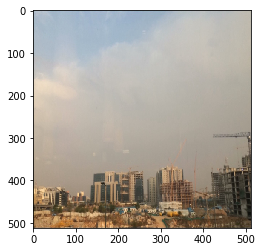

In [4]:
# displaying one image
plt.imshow(img_data[70,:,:,:])

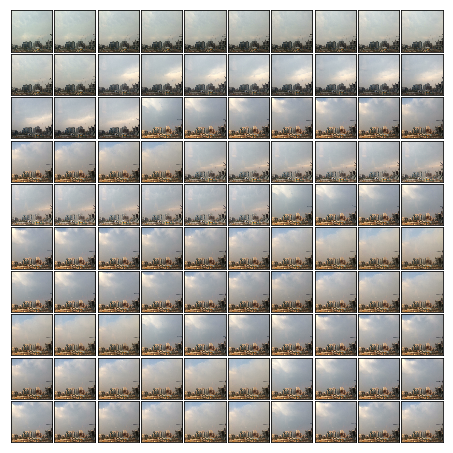

In [5]:
# Displaying all 100 images
# adapted from https://shankarmsy.github.io/posts/pca-sklearn.html

fig = plt.figure(figsize=(6,6)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
for i in range(100): 
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[]) 
    ax.imshow(img_data[i,:,:,:], interpolation='nearest') 
plt.show() 

# PCA

In [6]:
X = np.reshape(img_data, (img_data.shape[0],-1))
print(X.shape)

(100, 786432)


In [7]:
X_pca = X

In [8]:
pca = PCA(n_components=2)
pca.fit(X_pca)
X_r = pca.transform(X_pca)
print(X_r.shape)

(100, 2)


We will inspect how much variation of the orignal data set the components capture. The screeplot below shows that the first component explains about $60\%$ and the second around $15\%$.

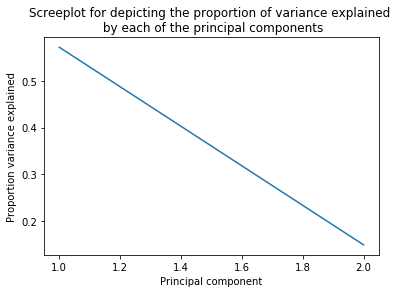

In [9]:
plt.plot(range(1,3), pca.explained_variance_ratio_)
plt.title('Screeplot for depicting the proportion of variance explained \n by each of the principal components')
plt.xlabel('Principal component')
plt.ylabel('Proportion variance explained')
plt.show()

The two components together can explain $72.1\%$ the original data:

In [10]:
np.cumsum(pca.explained_variance_ratio_)

array([0.57281264, 0.72074706])

# Visually Inspect the 2D Locations

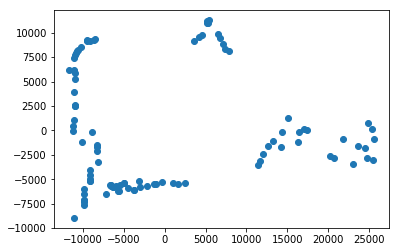

In [11]:
plt.scatter(X_r[:,0], X_r[:,1])

We see that the image points do form several different clusters. For example, there is one cluster on the top (at x=5000 and y=10000) that clearly stands out from the rest of the data. We will perform a couple of clustering methods and reconstruct images from each group.

## K-means

In [12]:
from sklearn.cluster import KMeans
n_clusters = 6
clustering = KMeans(n_clusters=n_clusters).fit(X_r)

In [13]:
def plot(n_clusters, labels):
# adapted from https://pythonspot.com/matplotlib-scatterplot/
    G = []
    data = []
    for i in range(n_clusters):
        G.append((X_r[labels == i, :][:,0], X_r[labels == i, :][:,1]))
    colors_pool = ["red", "green", "blue", 'magenta', 'orange', 'black']
    groups_pool = ["g0", "g1", "g2", 'g3', 'g4', 'g5']
    colors = colors_pool[:n_clusters]
    groups = groups_pool[:n_clusters]
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for data, color, group in zip(G, colors, groups):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

    plt.title('Matplot scatter plot')
    plt.legend(loc='best')
    plt.show()

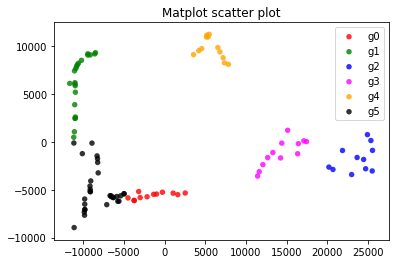

In [14]:
labels = clustering.labels_
plot(n_clusters, labels)

## Agglomerative

In the results of the k-means above, splitting the horizontal strand (where y=-5000) into two groups balck and red does not seem right to me, so I explored different clustering techniques in this page (https://scikit-learn.org/stable/modules/clustering.html) and finally picked AgglomerativeClustering that gave the satisfactory results:

In [15]:
from sklearn.cluster import AgglomerativeClustering
n_clusters = 6
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X_r)

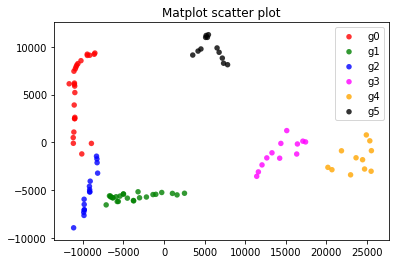

In [16]:
labels = clustering.labels_
plot(n_clusters, labels)

# Show the reconstruction from each low-dimensional representation

## Group 0

In [17]:
group = 0
n_samples = np.sum(labels == group)
print('Number of images in group', group, ':',  n_samples)
ind = labels==group

# Visualize the original images of this group
def viz_group_orig():
    fig = plt.figure(figsize=(10,10)) 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
    group_data = img_data[ind, :,:,:]
    for i in range(n_samples): 
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
        ax.imshow(group_data[i,:,:,:], interpolation='nearest') 
    plt.show()


Number of images in group 0 : 25


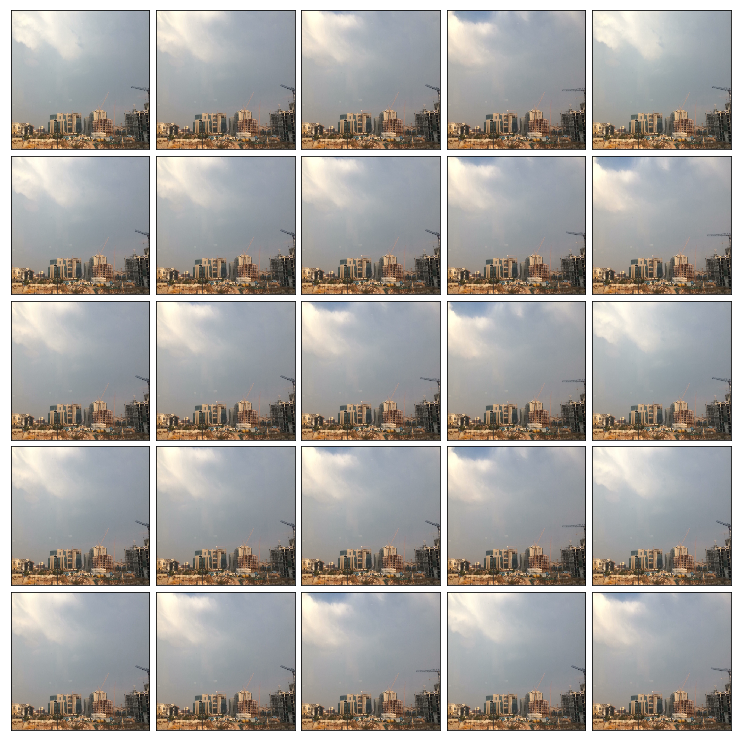

In [18]:
viz_group_orig()

In [19]:
# reconstructed images
def reconstruct_image():
    X_proj = X_r[ind, :]
    X_inv_proj = pca.inverse_transform(X_proj)
#     print(X_inv_proj.shape)
    X_proj_img = np.reshape(X_inv_proj,(n_samples,512,512,3))
    X_proj_img = X_proj_img.astype(int)
    return X_proj_img


In [20]:
X_proj_img = reconstruct_image()

In [21]:
# Visualize the reconstructed images of this group
def viz_group_rec():
    fig = plt.figure(figsize=(10,10)) 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
    #plot the faces, each image is 64 by 64 pixels 
    for i in range(n_samples): 
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
        ax.imshow(X_proj_img[i,:,:,:], interpolation='nearest') 
    plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

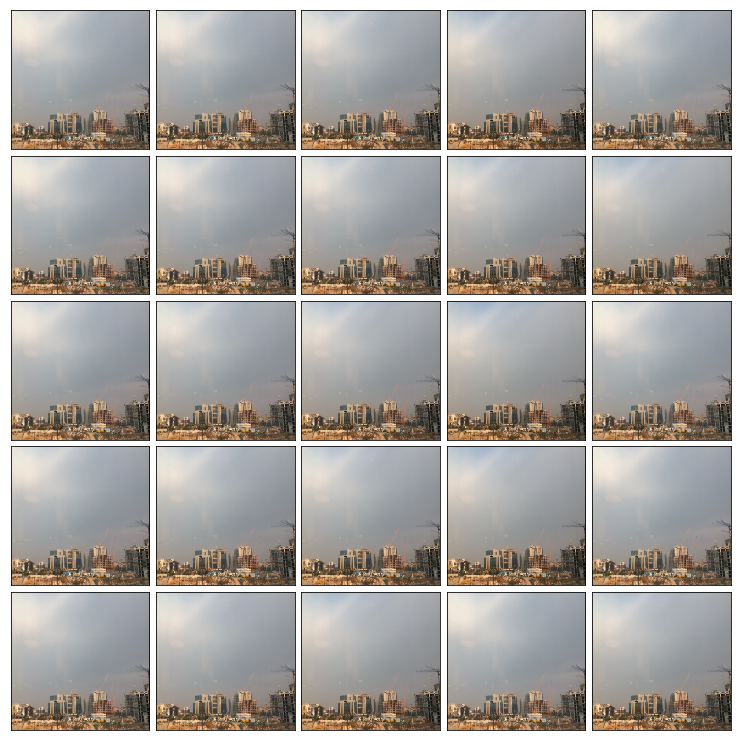

In [22]:
viz_group_rec();

## Group 1

In [23]:
group = 1
n_samples = np.sum(labels == group)
print('Number of images in group', group, ':',  n_samples)
ind = labels==group

Number of images in group 1 : 24


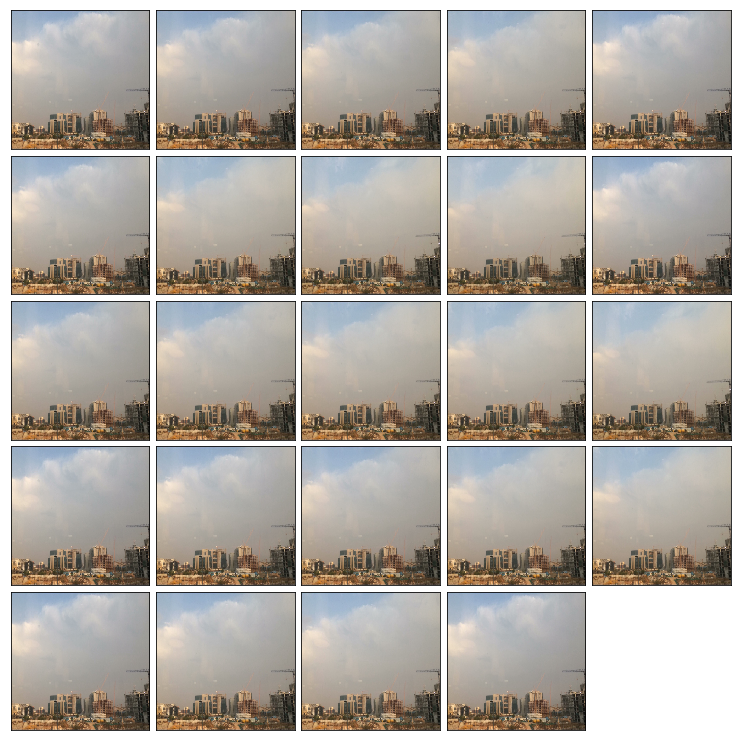

In [24]:
viz_group_orig()

In [25]:
X_proj_img = reconstruct_image()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


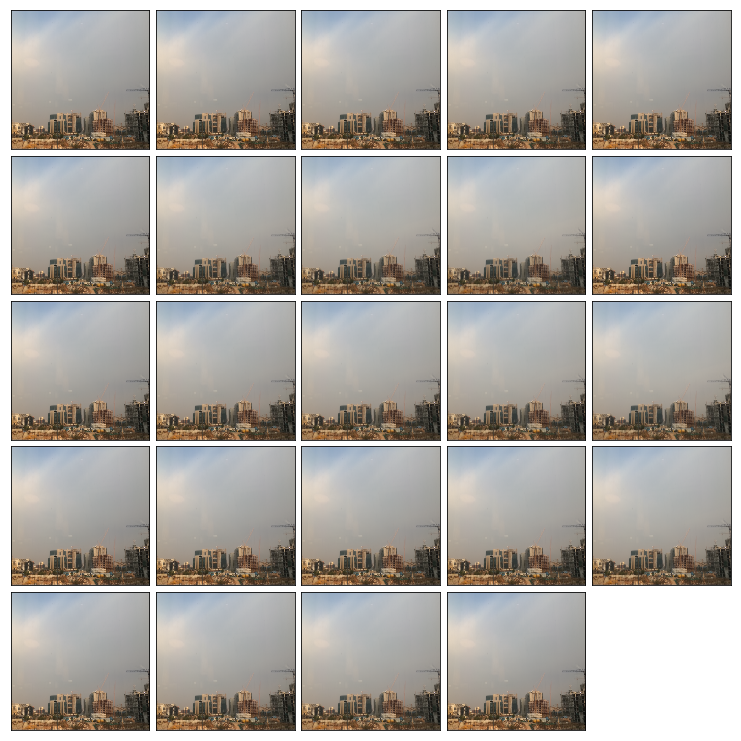

In [26]:
viz_group_rec()

## Group 2

Number of images in group 2 : 16


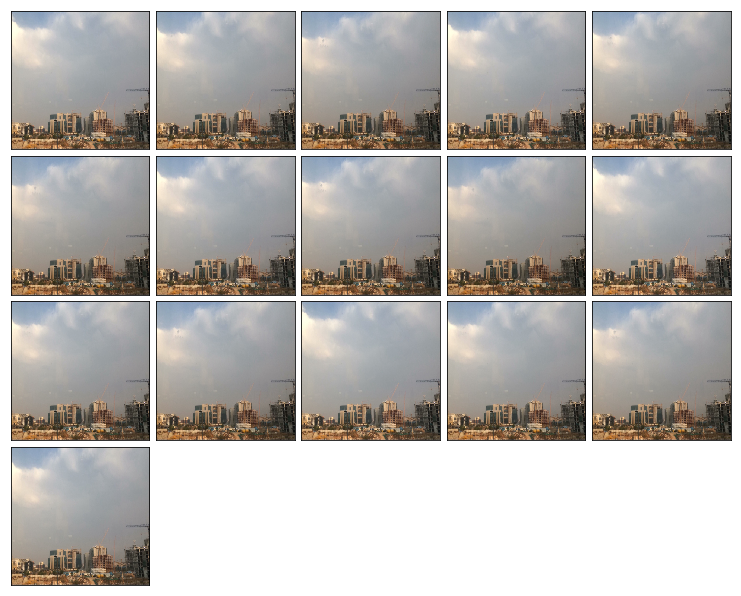

In [27]:
group = 2
n_samples = np.sum(labels == group)
print('Number of images in group', group, ':',  n_samples)
ind = labels==group
viz_group_orig()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

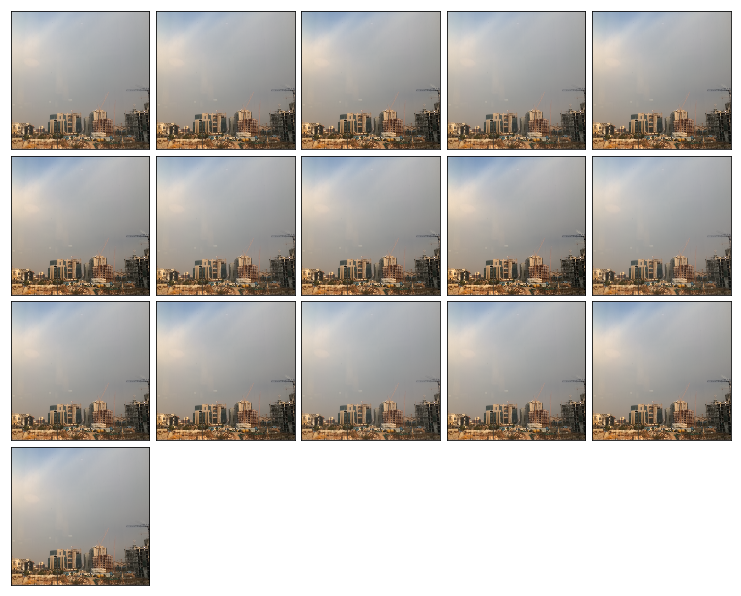

In [28]:
X_proj_img = reconstruct_image()
viz_group_rec()

# Group 3

Number of images in group 3 : 12


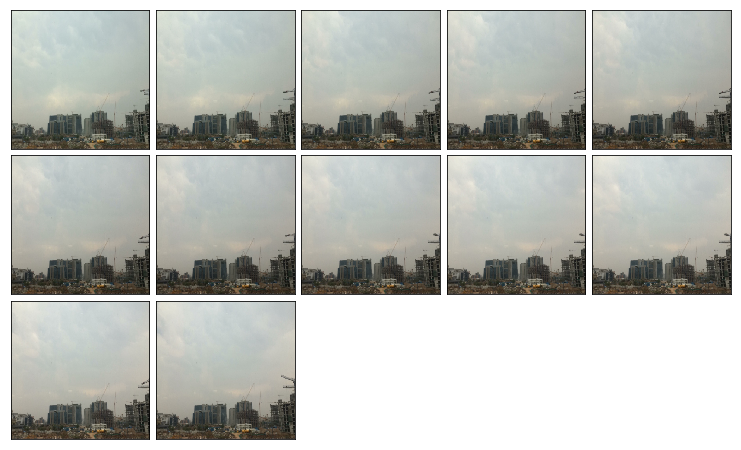

In [29]:
group = 3
n_samples = np.sum(labels == group)
print('Number of images in group', group, ':',  n_samples)
ind = labels==group
viz_group_orig()

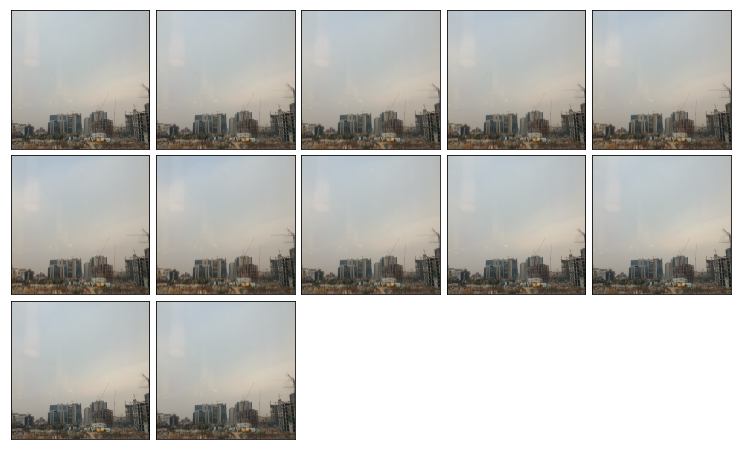

In [30]:
X_proj_img = reconstruct_image()
viz_group_rec()

# Group 4

Number of images in group 4 : 11


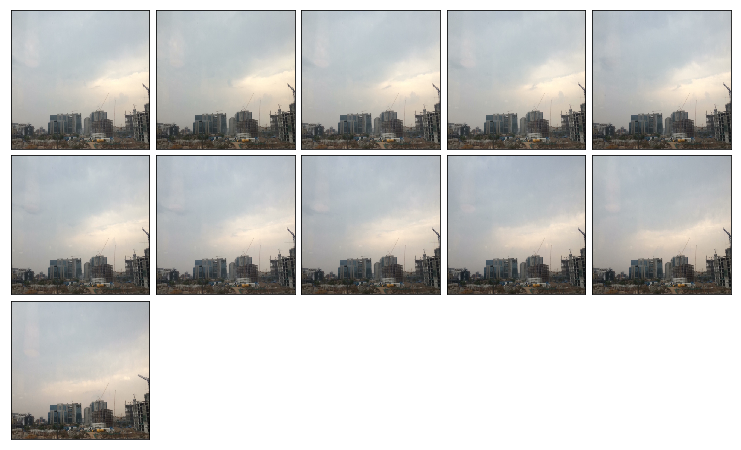

In [31]:
group = 4
n_samples = np.sum(labels == group)
print('Number of images in group', group, ':',  n_samples)
ind = labels==group
viz_group_orig()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


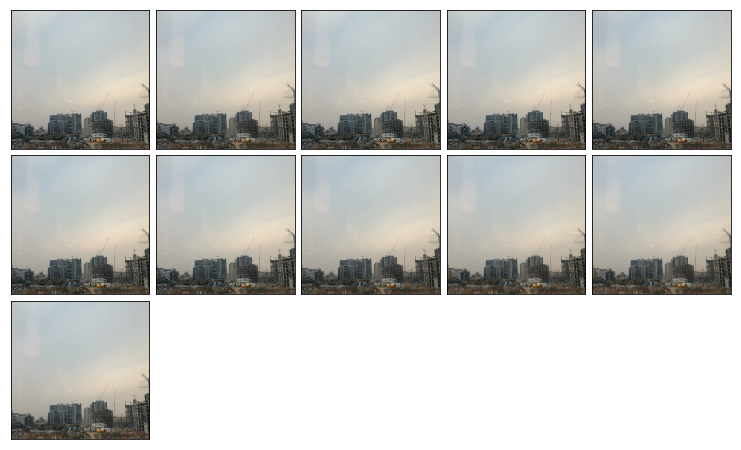

In [32]:
X_proj_img = reconstruct_image()
viz_group_rec()

# Group 5

Number of images in group 5 : 12


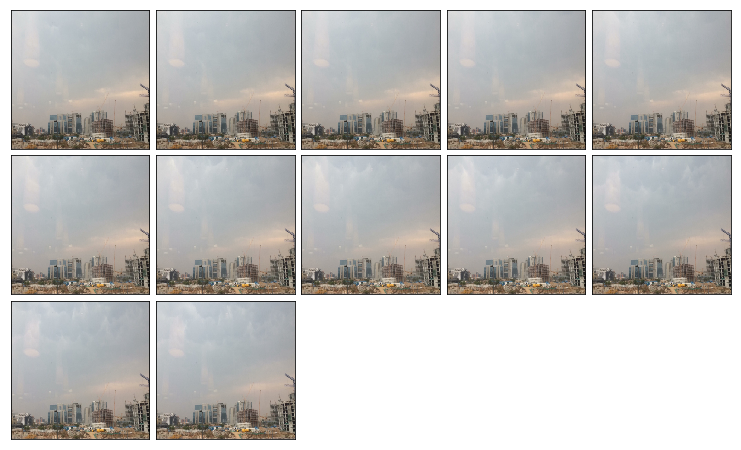

In [33]:
group = 5
n_samples = np.sum(labels == group)
print('Number of images in group', group, ':',  n_samples)
ind = labels==group
viz_group_orig()

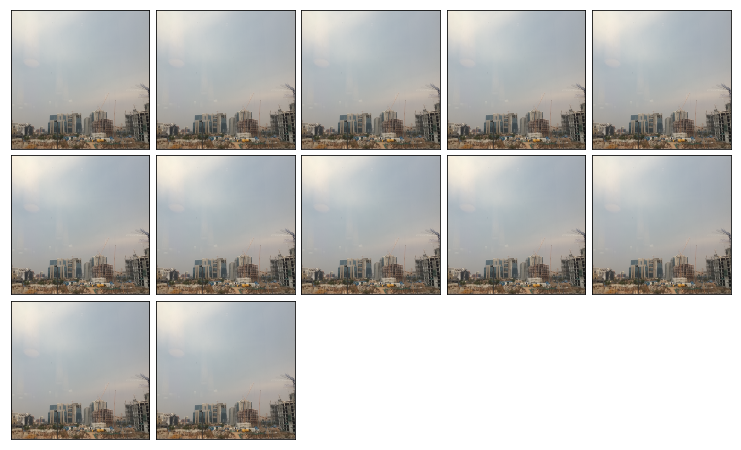

In [34]:
X_proj_img = reconstruct_image()
viz_group_rec()

# Finally pick a point that is far away from any known location and plot its reconstruction

We will explore two points. Both points are located at y=20000, but the first point has negative and the second point has positive value of x. For both points, its x and y coordinates are well outside the data range.

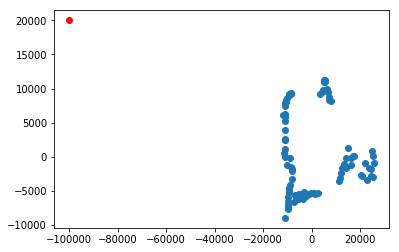

In [35]:
strange_point = [-100000, 20000]
plt.scatter(X_r[:,0], X_r[:,1])
plt.plot(strange_point[0], strange_point[1] ,'ro')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


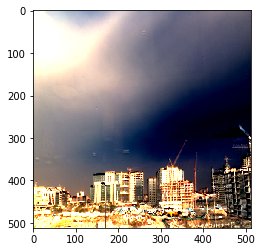

In [36]:
strange_point = np.reshape(np.array(strange_point), (1,-1))
X_proj = strange_point
X_inv_proj = pca.inverse_transform(X_proj)
X_proj_img = np.reshape(X_inv_proj,(1,512,512,3))
X_proj_img = X_proj_img.astype(int)
plt.imshow(X_proj_img[0,:,:,:])


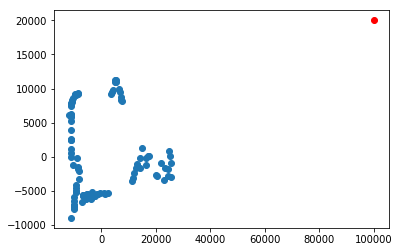

In [37]:
strange_point = [100000, 20000]
plt.scatter(X_r[:,0], X_r[:,1])
plt.plot(strange_point[0], strange_point[1] ,'ro')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


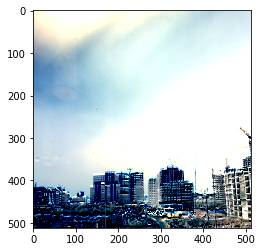

In [38]:
strange_point = np.reshape(np.array(strange_point), (1,-1))
X_proj = strange_point
X_inv_proj = pca.inverse_transform(X_proj)
X_proj_img = np.reshape(X_inv_proj,(1,512,512,3))
X_proj_img = X_proj_img.astype(int)
plt.imshow(X_proj_img[0,:,:,:])


# Discussion

1. Although there are only two components, the variation explained is large (~$72\%$). 

2. The 2D representation of the images does capture the commonalities of images captured in the same time period (the lighting, the clouds, etc.)

3. The reconstructed images mimic well the original ones, reflecting the nuances and differences between the groups. 

4. Images reconstructed from points that clearly does not belong to any groups in the original image set look, as expected, distinct from all the original images. 

5. The two images reconstructed from new points suggest that the x axis control/represent the brightness of the sky and the buildings. For example, when x=-100000, the sky is dark and the buildings are lightened up, and when x=+100000, the sky is bright and the buildings are darkened.